# Setup

In [1]:
!pip install scikit-optimize

     |████████████████████████████████| 101 kB 6.1 MB/s 


In [2]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, f1_score, precision_recall_curve, confusion_matrix
import matplotlib.pyplot as plt
from skopt import gp_minimize
from skopt.plots import plot_convergence
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras import backend as K
import joblib as jb
from lightgbm import LGBMClassifier, LGBMRegressor
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.compose import ColumnTransformer
import sys
PATH = "/content/drive/MyDrive/Colab Notebooks/Porto_Seguro_competition/"
sys.path.append(PATH)
sys.path.append(PATH + "pipeline")
# from utils_1_1 import *
from pipeline_functions import *
import warnings
import os
warnings.filterwarnings("ignore")

# Import Data

In [ ]:
APPROACH = 16
# list_remove = [44, 45, 46, 47, 48, 49, 50, 51, 55, 62, 63, 64, 65, 66, 31]
list_remove = [10,11,12,13,15,16,17,18,22,24,25,26,27,30,31,32,33,34,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,53,57,59,60,61,62,63,64,65,66,67,68]
list_remove = ['var'+str(x) for x in list_remove]

In [ ]:
df = pd.read_csv(PATH + "datasets/train.csv")
test_ = pd.read_csv(PATH + "datasets/test.csv")
submission_sample = pd.read_csv(PATH + "datasets/submission_sample.csv")
metadata = pd.read_csv(PATH + "datasets/metadata.csv")
metadata.columns = ["cod", "type"]

In [ ]:
def return_var_names(x):
  names = []
  for i in range(len(x)):
    names.append('var'+str(x[i]))
 
  return tuple(names)
list_combined_idx_cat = [(1,7), (1,20),(7,8),(7,20),(7,23),(7,28),(7,29), (7,39),(1,7,8),(1,7,14),(1,7,20),(1,7,23),(1,7,28),(1,7,29),(1,7,31),(1,7,39),(1,8,20),(1,8,23),(1,20,23),(1,20,28),(1,20,29),(1,20,39),(1,23,28)] #(1,8,20),(1,7,39),(1,8,23)(1,7,29),(1,7,31),(1,7,14),(1,7,23),(1,7,28)
list_combined_cat = [return_var_names(x) for x in list_combined_idx_cat]
combined_columns_cat = [f"{x[0]}_{x[1]}" if len(x) == 2 else f"{x[0]}_{x[1]}_{x[2]}"for x in list_combined_cat]
combined_columns_cat_categorify = [col + '_Categorify' for col in combined_columns_cat]
list_comb = [file.split("_") for file in os.listdir(PATH + "trees/kmeans")][:-1]
list_comb = [lt[:2] + [lt[2][:-4]] for lt in list_comb]
list_comb = sorted(list_comb, key= lambda x: x[2], reverse=True)[:15]
list_combined_num = [lt[:2] for lt in list_comb]
combined_columns_num = [f"{x[0]}_{x[1]}" for x in list_combined_num]

In [ ]:
num_dis = metadata[metadata.type == "Quantitativo discreto"].cod.to_list()
num_dis.remove("y")
num_con = metadata[metadata.type == "Quantitativo continua"].cod.to_list()
cat_nom = metadata[metadata.type == "Qualitativo nominal"].cod.to_list()
cat_nom.remove("id")
cat_ord = metadata[metadata.type == "Qualitativo ordinal"].cod.to_list() 
test_id = test_["id"]
y = df["y"].to_numpy().astype(np.float32)
test_.drop(["id"], axis=1, inplace=True)
df.drop(["id", "y"], axis=1, inplace=True)

### Approach 13

In [ ]:
class ProcessMissingValues_(BaseEstimator, TransformerMixin):
    def __init__(self, 
                columns,
                cat_columns,
                type_columns='categorical',
                num_imputer=None):
        self.columns = columns
        self.cat_columns = cat_columns
        self.type_columns = type_columns
        self.num_imputer = None
 
    def fit(self, X, y=None):
        return self
 
    def transform(self, X):
        if self.type_columns == 'categorical':
            X = self.transform_categorical(X)
 
        else:
            X = self.transform_numerical(X)
 
        return X
 
    def transform_categorical(self, X):
        for col in self.columns:
            X[col] = X[col].replace(-999, np.nan)
            # median = X[col].dropna().median()
            X['NA_' + col] = X[col].isna().astype(np.int8)
            X[col].fillna(-9999, inplace=True)
 
        return X
 
    def transform_numerical(self, X):
        self.columns = [col for col in X.columns if 'NA_' not in col and col not in self.cat_columns]
        for col in self.columns:
            X[col] = X[col].replace(-999, np.nan)
            if self.num_imputer == None:
                imputer = X[col].dropna().median()
            else:
                imputer = self.imputer
            X['NA_' + col] = X[col].isna().astype(np.int8)
            X = X.fillna(imputer)
 
        return X

In [ ]:
class Categorify_(BaseEstimator, TransformerMixin):
    def __init__(self, 
                columns,
                freq_treshhold=5,
                lowfrequency_id=0,
                unkown_id=1):
 
        self.columns = columns
        self.freqs = []
        self.freq_treshhold = freq_treshhold
        self.lowfrequency_id = lowfrequency_id
        self.unkown_id = unkown_id
 
    def fit(self, X, y=None):
        return self
 
    def transform(self, X):
        self.make_columns(X)
        for idx, col in enumerate(self.columns):
            col_name = self.freqs[idx].columns[0]
            df_copy = X.copy()
            df_copy[col] = df_copy[col].astype(str)
            df_copy = df_copy.merge(self.freqs[idx], how='left', on=col)
          
            X[col] = np.zeros(X.shape[0])
            X[col] = X[col].astype(int)
            X[col] = df_copy[col_name].copy()
            
 
 
 
        return X
 
    def make_columns(self, X):
        self.freqs = []
        for col in self.columns:
            freq = X[col].value_counts()
            freq = freq.reset_index()
            freq.columns = [col, 'count']
            freq = freq.reset_index()
            freq.columns = [col + '_Categorify', col, 'count']
            freq[col + '_Categorify'] = freq[col + '_Categorify'] + 2
            freq.loc[freq['count'] < self.freq_treshhold, col + '_Categorify'] = self.lowfrequency_id
            freq.loc[freq[col]==-9999, col + '_Categorify'] = self.unkown_id
            freq = freq.drop('count', axis=1)
            freq[col] = freq[col].astype(str)
            self.freqs.append(freq)

In [ ]:
X = pd.concat([df, test_])
X.drop(list_remove, axis=1, inplace=True)
num_dis = remove_feature(list_remove, num_dis)
num_con = remove_feature(list_remove, num_con)
cat_nom = remove_feature(list_remove, cat_nom)
cat_ord = remove_feature(list_remove, cat_ord)
all_columns = num_dis + num_con + cat_nom + cat_ord
num_pipeline = Pipeline([
    ('std_scaler', StandardScaler())
])
full_pipeline = ColumnTransformer([
    # ("replece_num_to_median", SimpleImputer(missing_values=-999, strategy="median"), all_columns),
    ("replece_num_to_median", ProcessMissingValues_(cat_columns=categorify_col, columns=cat_nom+cat_ord), all_columns),
    ('categorify', Categorify_(columns=cat_nom+cat_ord, freq_treshhold=5), all_columns),
    ('missing_values_num', ProcessMissingValues(cat_columns=cat_nom+cat_ord,
                                                  columns=num_dis+num_con, 
                                                  type_columns='numerical', 
                                                  num_imputer=None), all_columns),
    ("num", num_pipeline, num_dis + num_con),
    ("non_num", OneHotEncoder(), cat_nom + cat_ord)
])
 
X_prepared = full_pipeline.fit_transform(X)

### Approach 14

In [ ]:
class CombiningColumns_(BaseEstimator, TransformerMixin):
    def __init__(self, list_combined):
        self.list_combined = list_combined
 
    def fit(self, X):
        return self
 
    def transform(self, X):
        X = self.transform_cat(X)
        return X
 
    def transform_cat(self, X):
        for cols in self.list_combined:
            if len(cols) == 2:
                name_col = cols[0] + '_' + cols[1]
                X[name_col] = X[cols[0]].astype(str) + "_" +  X[cols[1]].astype(str)
            else:
                name_col = cols[0] + '_' + cols[1] + '_' + cols[2]
                X[name_col] = X[cols[0]].astype(str) + "_" +  X[cols[1]].astype(str) + '_' + X[cols[2]].astype(str)
 
        return X

In [ ]:
def remove_feature(list_remove, columns):
    return [x for x in columns if x not in list_remove]
X = pd.concat([df, test_])
for col in combined_columns_cat:
  X.loc[:, col] = X.loc[:, 'var1']
num_dis = remove_feature(list_remove, num_dis)
num_con = remove_feature(list_remove, num_con)
# cat_nom = remove_feature(list_remove, cat_nom)
# cat_ord = remove_feature(list_remove, cat_ord)
list_remove = list_remove + [col + '_Categorify' for col in list_remove]
all_columns = num_dis + num_con + cat_nom + cat_ord
categorify_col = [col + '_Categorify' for col in remove_feature(list_remove, cat_nom+cat_ord)]
 
cat_pipeline = Pipeline([
      ('missing_values_cat', ProcessMissingValues_(cat_columns=categorify_col, columns=cat_nom+cat_ord)),                       
      ('categorify1', Categorify_(columns=cat_nom+cat_ord, freq_treshhold=5)),
      ('combining_columns_cat', CombiningColumns_(list_combined=list_combined_cat)),
      ('categorify2', Categorify_(columns=combined_columns_cat, freq_treshhold=5)),
      ('get_rid_categorical_features', GetRidCategoricalFeatures(columns=list_remove))
 
]) 
 
num_pipeline = Pipeline([                     
      ('missing_values_num', ProcessMissingValues(cat_columns=cat_nom+cat_ord,
                                                  columns=num_dis+num_con, 
                                                  type_columns='numerical', 
                                                  num_imputer=None)),
      ('standard', StandardNumerical()) 
]) 
 
full_pipeline = ColumnTransformer([
    ("cat", cat_pipeline, all_columns),
    ("num", num_pipeline, all_columns),
    ("non_num", OneHotEncoder(), remove_feature(list_remove, num_dis) + combined_columns_cat)],
    remainder='passthrough')
X_prepared = full_pipeline.fit_transform(X)

In [ ]:
X_prepared.copy()
from scipy.sparse import vstack
X_, test = X_prepared[:df.shape[0], :], X_prepared[df.shape[0]:,:]
vstack((X_, test))

<35306x940 sparse matrix of type '<class 'numpy.float64'>'
	with 33187639 stored elements in Compressed Sparse Row format>

In [ ]:
(X_prepared[:, -2].A == 10).nonzero()[0]

array([    0,     1,     2, ..., 35303, 35304, 35305])

In [ ]:
X_, test = X_prepared[:df.shape[0], :], X_prepared[df.shape[0]:,:]
train, valid, y_train, y_valid = train_test_split(X_, y, test_size=0.4, random_state=42)
X_train0, X_train1, y_train0, y_train1 = train_test_split(train, y_train, test_size=0.4, random_state=42)

## save y and id

In [ ]:
save_y_and_id(APPROACH, y_train1, y_valid, test_id)

# Several hyperparameters

In [ ]:
tm = TuneModels(APPROACH, (X_train0, y_train0), (X_train1, y_train1), (valid, y_valid), test)

In [ ]:
# Defauts
tm.default_models()

Metrics -> lg = 0.4454477050413845 | lgbm = 0.6293769895407003 | xgb = 0.6584493041749503 | rf = 0.4525633470830878


In [ ]:
# Neural Nets
space = [(10, 600),
         (10, 600),
         (10, 60),
         (1e-5, 1e-3, 'log-uniform')]
res_nn = gp_minimize(tm.tune_nn, space, random_state=42, verbose=1, n_calls=30)

Iteration No: 1 started. Evaluating function at random point.
Epoch 1/49
159/159 [==============================] - 4s 9ms/step - loss: 0.7781 - f1_m: 0.2223 - precision_m: 0.1987 - recall_m: 0.4893 - val_loss: 0.6465 - val_f1_m: 0.3530 - val_precision_m: 0.2235 - val_recall_m: 0.9221
Epoch 2/49
159/159 [==============================] - 1s 7ms/step - loss: 0.6815 - f1_m: 0.3185 - precision_m: 0.2267 - recall_m: 0.6231 - val_loss: 0.6820 - val_f1_m: 0.3172 - val_precision_m: 0.2295 - val_recall_m: 0.5666
Epoch 3/49
159/159 [==============================] - 1s 7ms/step - loss: 0.6822 - f1_m: 0.3176 - precision_m: 0.2322 - recall_m: 0.5536 - val_loss: 0.6949 - val_f1_m: 0.3043 - val_precision_m: 0.2570 - val_recall_m: 0.4122
Epoch 4/49
159/159 [==============================] - 1s 7ms/step - loss: 0.7013 - f1_m: 0.2984 - precision_m: 0.2524 - recall_m: 0.4807 - val_loss: 0.6944 - val_f1_m: 0.3049 - val_precision_m: 0.2382 - val_recall_m: 0.4703
Epoch 5/49
159/159 [======================

In [ ]:
# Logistic Regressor
space = [(1e-8, 1e-6, 'log-uniform'),
         (100, 500),
         (1, 15)]
 
res_lr = gp_minimize(tm.tune_logistic, space, random_state=42, verbose=1, n_calls=30)
plot_convergence(res_lr )

Iteration No: 1 started. Evaluating function at random point.
[3.918194347141745e-07, 173, 12] 0.5621380846325167

Iteration No: 1 ended. Evaluation done at random point.
Time taken: 117.3949
Function value obtained: -0.5621
Current minimum: -0.5621
Iteration No: 2 started. Evaluating function at random point.
[1.5620693675639854e-07, 278, 2] 0.5690846286701209

Iteration No: 2 ended. Evaluation done at random point.
Time taken: 221.3285
Function value obtained: -0.5691
Current minimum: -0.5691
Iteration No: 3 started. Evaluating function at random point.
[8.288916866885136e-08, 233, 3] 0.5693304535637149

Iteration No: 3 ended. Evaluation done at random point.
Time taken: 195.9320
Function value obtained: -0.5693
Current minimum: -0.5693
Iteration No: 4 started. Evaluating function at random point.
[2.0034427927560744e-07, 123, 11] 0.5621380846325167

Iteration No: 4 ended. Evaluation done at random point.
Time taken: 45.6462
Function value obtained: -0.5621
Current minimum: -0.5693
I

KeyboardInterrupt: ignored

Iteration No: 1 started. Evaluating function at random point.
[715, 113, 594, 0.00027235696685182486] 0.6204178163184864

Iteration No: 1 ended. Evaluation done at random point.
Time taken: 3.2833
Function value obtained: -0.6204
Current minimum: -0.6204
Iteration No: 2 started. Evaluating function at random point.
[669, 135, 220, 0.05446342360286173] 0.6254789272030652

Iteration No: 2 ended. Evaluation done at random point.
Time taken: 1.3959
Function value obtained: -0.6255
Current minimum: -0.6255
Iteration No: 3 started. Evaluating function at random point.
[282, 501, 467, 0.03382011354260531] 0.6500415627597672

Iteration No: 3 ended. Evaluation done at random point.
Time taken: 1.2742
Function value obtained: -0.6500
Current minimum: -0.6500
Iteration No: 4 started. Evaluating function at random point.
[528, 282, 264, 0.0016038912774756226] 0.5992049150704734

Iteration No: 4 ended. Evaluation done at random point.
Time taken: 0.9356
Function value obtained: -0.5992
Current mini

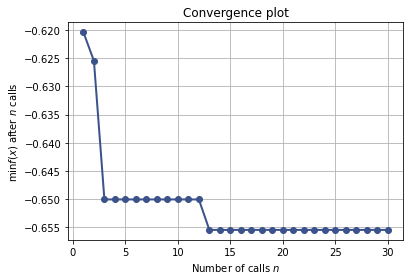

In [ ]:
# Lgbm
space = [(200, 1000),
         (1, 1000),
         (100, 800),
         (1e-4, 1e-1, 'log-uniform')]
 
res_lgbm = gp_minimize(tm.tune_lgbm, space, random_state=42, verbose=1, n_calls=30)
plot_convergence(res_lgbm)

In [ ]:
# XGBoost
space = [
    (1e-3, 9e-1, 'log-uniform'),
    (3, 30),
    (0.01, 20.0, 'log-uniform'),
    (0.2, 1.0),
    (0.2, 1.0),
    [1, 2, 3],
    (100, 1000)
]
 
res_xgb = gp_minimize(tm.tune_xgboost, space, random_state=42, verbose=1, n_calls=50)
plot_convergence(res_xgb)

Iteration No: 1 started. Evaluating function at random point.
[0.22551796937629706, 8, 3.7478601695703286, 0.6774801263571897, 0.556666202282873, 1, 513] 0.6385964912280703

Iteration No: 1 ended. Evaluation done at random point.
Time taken: 3.9504
Function value obtained: -0.6386
Current minimum: -0.6386
Iteration No: 2 started. Evaluating function at random point.
[0.009679572227018539, 7, 1.4079990864907204, 0.24512926322168022, 0.77759901781346, 3, 101] 0.6333808844507846

Iteration No: 2 ended. Evaluation done at random point.
Time taken: 6.0055
Function value obtained: -0.6334
Current minimum: -0.6386
Iteration No: 3 started. Evaluating function at random point.
[0.8535590410250283, 20, 1.044925745499645, 0.20565304417577393, 0.21844994003313262, 2, 460] 0.5847853803654909

Iteration No: 3 ended. Evaluation done at random point.
Time taken: 2.8124
Function value obtained: -0.5848
Current minimum: -0.6386
Iteration No: 4 started. Evaluating function at random point.
[0.00137360444

In [ ]:
# Random Forest
space = [(1, 30),
         (1.0, 5.5),
         (1, 30),
         (100, 1300)]
 
res_rf = gp_minimize(tm.tune_trees, space, random_state=42, verbose=1, n_calls=40)

Iteration No: 1 started. Evaluating function at random point.
[24, 1.8254565543977372, 24, 816] 0.611470113085622

Iteration No: 1 ended. Evaluation done at random point.
Time taken: 19.9039
Function value obtained: -0.6115
Current minimum: -0.6115
Iteration No: 2 started. Evaluating function at random point.
[14, 1.4498871211810131, 14, 500] 0.615699100572363

Iteration No: 2 ended. Evaluation done at random point.
Time taken: 14.3136
Function value obtained: -0.6157
Current minimum: -0.6157
Iteration No: 3 started. Evaluating function at random point.
[5, 3.9289981282698383, 3, 966] 0.5524261961316594

Iteration No: 3 ended. Evaluation done at random point.
Time taken: 10.1958
Function value obtained: -0.5524
Current minimum: -0.6157
Iteration No: 4 started. Evaluating function at random point.
[28, 1.0035044462845646, 30, 841] 0.598438855160451

Iteration No: 4 ended. Evaluation done at random point.
Time taken: 19.2084
Function value obtained: -0.5984
Current minimum: -0.6157
Itera

Iteration No: 1 started. Evaluating function at random point.
[30] 0.3825767515087904

Iteration No: 1 ended. Evaluation done at random point.
Time taken: 25.9064
Function value obtained: -0.3826
Current minimum: -0.3826
Iteration No: 2 started. Evaluating function at random point.
[8] 0.33866562621927426

Iteration No: 2 ended. Evaluation done at random point.
Time taken: 25.4965
Function value obtained: -0.3387
Current minimum: -0.3826
Iteration No: 3 started. Evaluating function at random point.
[29] 0.3783783783783784

Iteration No: 3 ended. Evaluation done at random point.
Time taken: 25.7560
Function value obtained: -0.3784
Current minimum: -0.3826
Iteration No: 4 started. Evaluating function at random point.
[22] 0.35589450270098505

Iteration No: 4 ended. Evaluation done at random point.
Time taken: 25.5880
Function value obtained: -0.3559
Current minimum: -0.3826
Iteration No: 5 started. Evaluating function at random point.
[17] 0.3817034700315457

Iteration No: 5 ended. Evalu

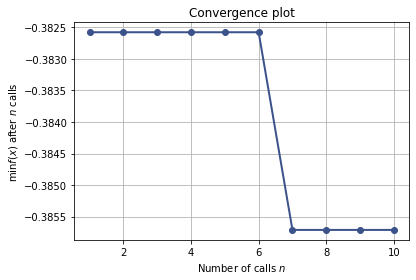

In [ ]:
# KNN
space = [(1, 37)]

res_knn = gp_minimize(tm.tune_knn, space, random_state=42, verbose=1, n_calls=10)
plot_convergence(res_knn)

### Notes

**NN**
 
* Approach 4:  0.5563
 
* Approach 5: 0.5454545454545454
 
* Approach 7: 0.6229177183240788
 
* Approach 10: 0.4894
 
* Approach 11: 0.5419

* Approach 12: 0.5420 
 
**Logistic Regressor**
 
* Approach 4: 0.5448343079922028
 
* Approach 5: 0.5429943256219991
 
* Approach 6: 0.5403001667593107
 
* Approach 7: 0.6258426966292134
 
* Approach 10: 0.5617
 
* Approach 11: 0.5582
 
**LGBM**
 
* Approach 4: 0.6058666666666668
 
* Approach 5: 0.6074313408723748
 
* Approach 6: 0.5954035275253875
 
* Approach 7: 0.6367713004484306
 
* Approach 10: 0.6564
 
* Approach 11: 0.6564144071226224

* Approach 12: 0.66
 
**XGBoost**
 
* Approach 4: 0.5993071593533489
 
* Approach 5: 0.6017391304347827
 
* Approach 6: 0.6017391304347827
 
* Approach 7: 0.6415525114155252 overfitting
 
* approach 10: 0.6644 
 
* Approach 11: 0.6716
 
**Random Forest**
 
* Approach 4: 0.58719646799117
 
* approach 5: 0.577240241891149
 
* approach 6: 0.5343000557724484
 
* approach 7: 0.6177083333333333
 
* Approach 10: 0.6123
 
* Approach 11: 0.5970
 
**KNN**
 
* Approach 10: 0.5104
 
* Approach 11: 0.3435

# Neural Net with dropout

Iteration No: 1 started. Evaluating function at random point.
Epoch 1/32
159/159 [==============================] - 3s 9ms/step - loss: 0.6978 - f1_m: 0.3021 - precision_m: 0.2076 - recall_m: 0.6127 - val_loss: 0.7549 - val_f1_m: 0.2454 - val_precision_m: 0.1885 - val_recall_m: 0.3840
Epoch 2/32
159/159 [==============================] - 1s 7ms/step - loss: 0.7058 - f1_m: 0.2941 - precision_m: 0.2052 - recall_m: 0.5849 - val_loss: 0.7561 - val_f1_m: 0.2443 - val_precision_m: 0.2053 - val_recall_m: 0.3388
Epoch 3/32
159/159 [==============================] - 1s 7ms/step - loss: 0.7166 - f1_m: 0.2836 - precision_m: 0.1971 - recall_m: 0.5731 - val_loss: 0.7706 - val_f1_m: 0.2295 - val_precision_m: 0.2077 - val_recall_m: 0.2834
Epoch 4/32
159/159 [==============================] - 1s 7ms/step - loss: 0.7079 - f1_m: 0.2921 - precision_m: 0.2034 - recall_m: 0.5656 - val_loss: 0.7525 - val_f1_m: 0.2480 - val_precision_m: 0.2140 - val_recall_m: 0.3277
Epoch 5/32
159/159 [======================

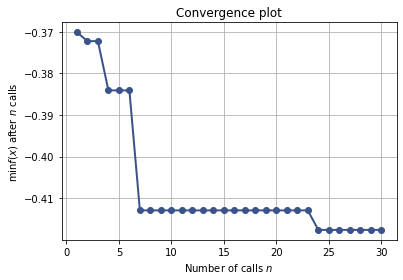

In [ ]:
space = [(10, 600),
         (10, 600),
         (0.0, 0.95),
         (0.0, 0.95),
         (10, 60),
         (1e-5, 1e-3, 'log-uniform')]

res_nn = gp_minimize(tm.tune_nn_dropout, space, random_state=42, verbose=1, n_calls=30)
plot_convergence(res_nn)

# Group Features 

For while, I only can do group of numerical features.

In [ ]:
groups = {
    'num_dis': num_dis,
    'num_con': num_con
}
X = pd.concat([df, test_])
X.drop(list_remove, axis=1, inplace=True)
mfg = ModelFeaturesGroups(groups, APPROACH, num_pipeline, X, df.shape[0], y)

In [ ]:
mfg.LR_1_group([1e-08, 500, 1])

['var24', 'var25', 'var27', 'var40', 'var52', 'var53', 'var54', 'var67', 'var68']


TypeError: ignored

In [ ]:
mfg.LGBM_1_group([837, 184, 646, 0.006173770394704579])

TypeError: ignored

# Group Lines

In [ ]:
mrg = ModelRowGroups(APPROACH, (X_train0, y_train0), (X_train1, y_train1), (valid, y_valid), test)

In [ ]:
mrg.XGboost()

NameError: ignored

In [ ]:
mrg.LGBM()

IndexError: ignored